# Generate a Noise Model using Bootstrapping

Here we assume that we do not have access to calibration data to create a noise model for training DivNoising. In this case, we use an approach called ```Bootstrapping``` to create a noise model from noisy data itself. The idea is that we will first use the unsupervised denoising method Noise2Void to obtain denoised images corresponding to our noisy data. Then we will treat the denoised images as pseudo GT corresponding to the noisy data and use the pair of noisy images and corresponding Noise2Void denoised images to learn a noise model.

DivNoising when using bootstrapped noise model generally gives better results compared to Noise2Void denoising. Also, unlike Noise2Void, we additionally obtain diverse denoised samples corresponding to any noisy image unlike Noise2Void.

__Note:__ Denoising methods other than Noise2Void can also be used to obtain pseudo GT for bootsrapping a noise model.

In [8]:
import warnings
warnings.filterwarnings('ignore')
import torch
import os
import urllib
import zipfile
from torch.distributions import normal
import matplotlib.pyplot as plt, numpy as np, pickle
from scipy.stats import norm
from tifffile import imread
import sys
sys.path.append('../../')
from divnoising.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel
from divnoising import histNoiseModel
from divnoising.utils import plotProbabilityDistribution

import torch
import matplotlib.pyplot as plt
import numpy as np
from careamics import CAREamist
from careamics.config import create_n2v_configuration
from careamics.utils.metrics import scale_invariant_psnr
from careamics_portfolio import PortfolioManager
from PIL import Image

dtype = torch.float
device = torch.device("cuda:0")

In [9]:
use_gpu  = "yes" if len([torch.cuda.get_device_properties(i) for i in range(torch.cuda.device_count())]) > 0 else "no"
print(f"Using GPU: {use_gpu}")

Using GPU: yes


### Load SDTrans data

In [10]:
observation= imread('../../data/SDTrans/noise_200Hz_2400frames_pxlsize30nm_3.90dBSNR_24000x328x328.tif')
#Load the noisy data to be denoised

# load the first 1000 frames
observation = observation[:1000]
print(observation.shape)
print(observation.dtype)
print(type(observation))

(1000, 328, 328)
int16
<class 'numpy.ndarray'>


### Visualize the noisy data

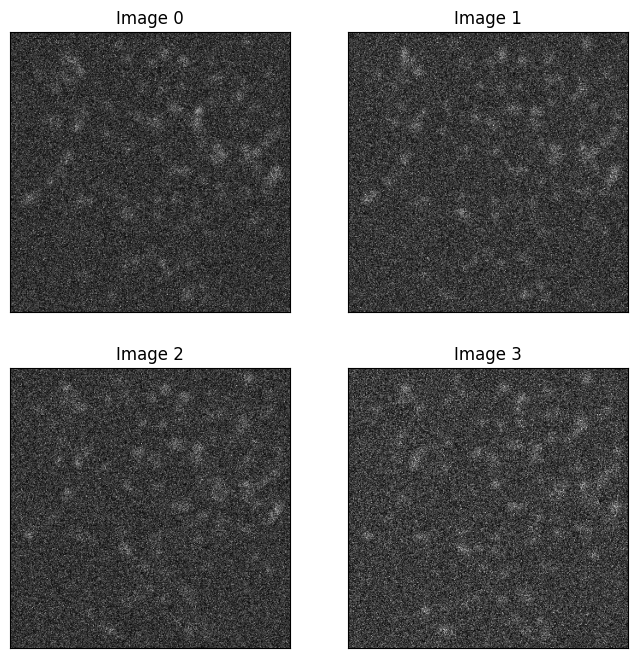

In [11]:
indices=[0,1,2,3]
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].imshow(observation[indices[0]], cmap="gray")
ax[0, 0].set_title(f"Image {indices[0]}")
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[0, 1].imshow(observation[indices[1]], cmap="gray")
ax[0, 1].set_title(f"Image {indices[1]}")
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

ax[1, 0].imshow(observation[indices[2]], cmap="gray")
ax[1, 0].set_title(f"Image {indices[2]}")
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

ax[1, 1].imshow(observation[indices[3]], cmap="gray")
ax[1, 1].set_title(f"Image {indices[3]}")
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

plt.show()

### Config the training settings

In [12]:
config = create_n2v_configuration(
    experiment_name="SDTrans_n2v",
    data_type="array",
    axes="SYX",
    patch_size=(32, 32),
    batch_size=8,
    num_epochs=10,
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 1,
                                'use_batch_norm': True},
                      'n2v_config': {'masked_pixel_percentage': 0.2,
                                     'name': 'N2VManipulate',
                                     'remove_center': True,
                                     'roi_size': 11,
                    

### Train the noise model

In [14]:
# instantiate a CAREamist

careamist = CAREamist(source=config)

train_data=observation

# train
careamist.train(
    train_source=train_data,
)


No working directory provided. Using current working directory: /root/autodl-tmp/examples/Mouse_nuclei.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 333 K  | train
---------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.335     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


### Figure the loss curve

{'epoch': [], 'learning_rate': [], 'step': [], 'train_loss_epoch': [], 'train_loss_step': [], 'val_loss': []}


Text(0.5, 1.0, 'Losses')

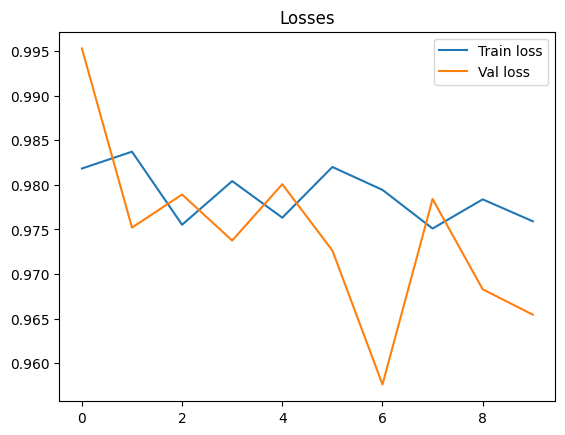

In [15]:
loss_dict = careamist.get_losses()
plt.plot(loss_dict["train_epoch"], loss_dict["train_loss"], loss_dict["val_epoch"], loss_dict["val_loss"])
plt.legend(["Train loss", "Val loss"])
plt.title("Losses")

### Save the pseudo groundtruth

In [17]:
from tifffile import imwrite
prediction = careamist.predict(source=train_data)

output_path = "prediction_result.tif"

imwrite("prediction_result.tif", prediction)


print(f"Saved multi-frame TIFF to {output_path}")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Saved multi-frame TIFF to prediction_result.tif


### Bulid the noise model Hist and GMM

In [19]:
path = './data/Mouse_skull_nuclei/'
dataName = 'SDTrans' # Name of the noise model
n_gaussian = 3 # Number of gaussians to use for Gaussian Mixture Model
n_coeff = 2 # No. of polynomial coefficients for parameterizing the mean, standard deviation and weight of Gaussian components.

In [20]:
nameHistNoiseModel ='HistNoiseModel_'+dataName+'_'+'bootstrap'
nameGMMNoiseModel = 'GMMNoiseModel_'+dataName+'_'+str(n_gaussian)+'_'+str(n_coeff)+'_'+'bootstrap'

Signal shape: (1000, 328, 328)
Observation shape: (1000, 328, 328)


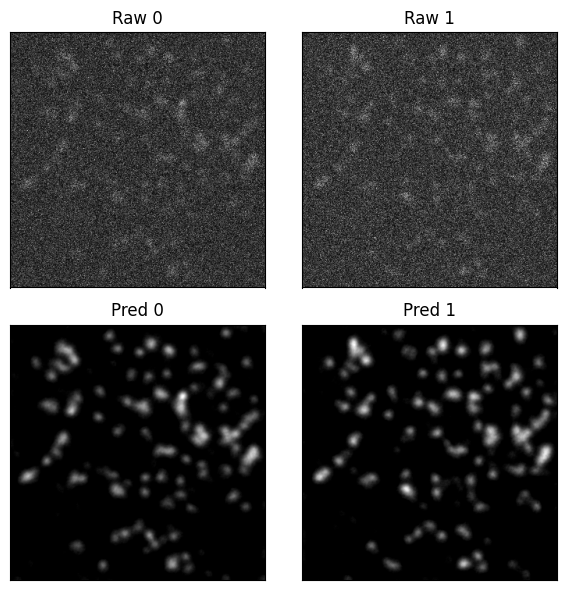

In [27]:
# Let's look the raw data and our pseudo ground truth signal
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff

# read the prediction
signal = np.squeeze(tiff.imread("prediction_result.tif"))  # → (N,H,W)
print("Signal shape:", signal.shape)

#observation transfer to numpy and squeeze
try:
    observation_np = observation.cpu().numpy()
except:
    observation_np = observation

observation_np = np.squeeze(observation_np)
print("Observation shape:", observation_np.shape)

# indices
indices = [0, 1]

# Figure the plot
fig, ax = plt.subplots(2, 2, figsize=(6, 6))

for i, idx in enumerate(indices):

    # Raw image
    ax[0, i].imshow(observation_np[idx], cmap="gray")
    ax[0, i].set_title(f"Raw {idx}")
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])

    # Prediction (pseudo ground truth)
    ax[1, i].imshow(signal[idx], cmap="gray")
    ax[1, i].set_title(f"Pred {idx}")
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])

plt.tight_layout()
plt.show()


### Creating the Histogram Noise Model

Using the raw pixels $x_i$, and our averaged GT $s_i$, we are now learning a histogram based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [32]:
# We set the range of values we want to cover with our model.
# The pixel intensities in the images you want to denoise have to lie within this range.
print(observation.min(), observation.max())
print(signal.min(), signal.max())
minVal, maxVal = -200, 1900
bins = 400

# We are creating the histogram.
# This can take a minute.
histogram = histNoiseModel.createHistogram(bins, minVal, maxVal, observation,signal)

# Saving histogram to disc.
np.save(nameHistNoiseModel+'.npy', histogram)
histogramFD=histogram[0]

-79 1758
201.05453491210938 740.9779663085938


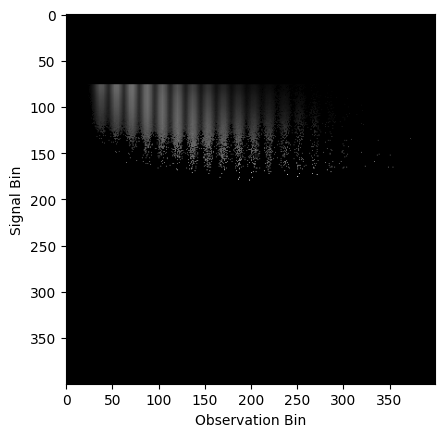

In [33]:
# Let's look at the histogram-based noise model.
plt.xlabel('Observation Bin')
plt.ylabel('Signal Bin')
plt.imshow(histogramFD**0.25, cmap='gray')
plt.show()

### Creating the GMM noise model
Using the raw pixels $x_i$, and our averaged GT $s_i$, we are now learning a GMM based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [34]:
min_signal=np.percentile(signal, 0.5)
max_signal=np.percentile(signal, 99.5)
print("Minimum Signal Intensity is", min_signal)
print("Maximum Signal Intensity is", max_signal)

Minimum Signal Intensity is 201.7901153564453
Maximum Signal Intensity is 352.67077651977525


In [35]:
min_signal=np.min(signal)
max_signal=np.max(signal)
print("Minimum Signal Intensity is", min_signal)
print("Maximum Signal Intensity is", max_signal)

Minimum Signal Intensity is 201.05453491210938
Maximum Signal Intensity is 740.9779663085938


Iterating the noise model training for `n_epoch=4000` and `batchSize=25000` works the best for `Mouse nuclei` dataset. 

In [41]:
gaussianMixtureNoiseModel = GaussianMixtureNoiseModel(min_signal = min_signal, max_signal =max_signal, 
                                                      path="", weight = None, n_gaussian = n_gaussian,
                                                      n_coeff = n_coeff, min_sigma = 50, device = device)

In [42]:
gaussianMixtureNoiseModel.train(signal, observation, batchSize = 25000, n_epochs = 4000, learning_rate=0.1, 
                                name = nameGMMNoiseModel, lowerClip = 0.5, upperClip = 99.5)

0 19.832103729248047
100 6.3636674880981445
200 6.3303937911987305
300 6.326231002807617
400 6.320481300354004
500 6.328087329864502
600 6.324392318725586
700 6.327507972717285
800 6.325843811035156
900 6.322181224822998
1000 6.320558547973633
1100 6.328647136688232
1200 6.329644680023193
1300 6.324870586395264
1400 6.318208694458008
1500 6.324538707733154
1600 6.326558589935303
1700 6.320647239685059
1800 6.325022220611572
1900 6.320877552032471
2000 6.324772357940674
2100 6.317142486572266
2200 6.316243648529053
2300 6.312556743621826
2400 6.319840431213379
2500 6.317233562469482
2600 6.318357467651367
2700 6.31956672668457
2800 6.314062118530273
2900 6.312107563018799
3000 6.314250946044922
3100 6.320144176483154
3200 6.309848785400391
3300 6.308706283569336
3400 6.316553592681885
3500 6.308000564575195
3600 6.307159900665283
3700 6.30159854888916
3800 6.307077407836914
3900 6.306290626525879

The trained parameters (GMMNoiseModel_SDTrans_3_2_bootstrap) is saved at location: 


### Visualizing the Histogram-based and GMM-based noise models

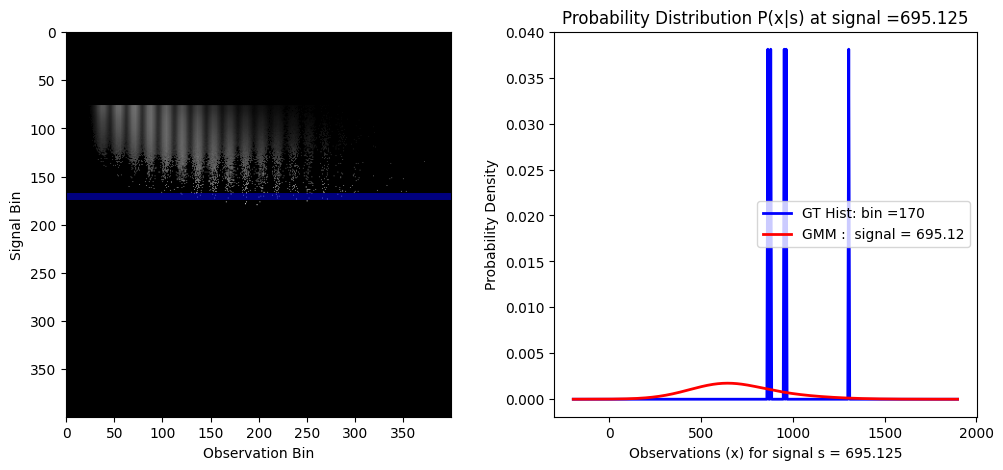

In [43]:
plotProbabilityDistribution(signalBinIndex=170, histogram=histogramFD, 
                            gaussianMixtureNoiseModel=gaussianMixtureNoiseModel, min_signal=minVal, 
                            max_signal=maxVal, n_bin= bins, device=device)